In [3]:
import pathlib
import datetime
import re

import ipywidgets
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import statsmodels.tsa.seasonal
import statsmodels.regression
import statsmodels.nonparametric.smoothers_lowess
import numpy as np


%matplotlib inline

In [25]:
prop_cycle = matplotlib.rcParams['axes.prop_cycle']

colors = dict(
    zip(
        ['linear', 'quadratic', 'lowess', 'STL'], 
        prop_cycle.by_key()['color']
    )
)

# which variable to use for global sea level
variable = 'GMSL'

In [26]:
path = pathlib.Path('~/src/sealevel/data/nasa/gmsl.txt').expanduser()

In [27]:
with path.open() as f:
    lines = f.readlines()


In [28]:
for i, line in enumerate(lines):
    if 'HDR column description' in line:
        column_start = i + 1
    if 'HDR Header_End' in line:
        skiprows = i + 1
        
pattern = re.compile(r'^HDR([*]?) (?P<number>\d+) (?P<name>.*)$')

columns = []
for line in lines[column_start:(column_start+12)]:
    columns.append(pattern.match(line).group('name'))

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


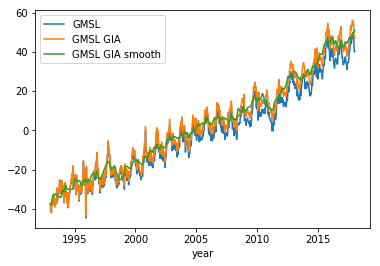

In [29]:
df = pd.read_csv(path, skiprows=skiprows, names=columns, sep='\s+')
df.head()
df = df.iloc[:, [2, 6-1, 9-1, 12-1]]
df.columns = ['year', 'GMSL', 'GMSL GIA', 'GMSL GIA smooth']


def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime.datetime(year, 1, 1)
    eoy = datetime.datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + datetime.timedelta(seconds=seconds)

df['date'] = pd.Series(df.year).apply(t2dt)

df = df.set_index('year')
df.plot(y=['GMSL', 'GMSL GIA', 'GMSL GIA smooth'])

In [30]:
def make_models(series, epoch):
    exog_quadratic = np.c_[series.index - epoch, (series.index - epoch)**2]
    exog_linear = np.c_[series.index - epoch]
    # sea-level is relative to 20-year TOPEX/Jason collinear mean reference
    # explicitly without constant because the data starts at 0 and it makes the models comparable.
    endog = series - series.iloc[0]
    linear_model = statsmodels.regression.linear_model.OLS(endog, exog_linear)
    quadratic_model = statsmodels.regression.linear_model.OLS(endog, exog_quadratic)
    return {
        "quadratic": quadratic_model.fit(),
        "linear": linear_model.fit()
    }

def plot(year=(2000, 2019)):

    
    selected = df[df.index <= year]
    epoch = selected.index[0]

    models = make_models(series=selected[variable], epoch=epoch)
    

    
    # sea-level is relative to 20-year TOPEX/Jason collinear mean reference
    # let's switch to 1990 level, for easy comparison
    gmsl = df[variable] - selected[variable].iloc[0]
    gmsl_selected = selected[variable] - selected[variable].iloc[0]

    fig, axes = plt.subplots(2, 1, figsize=(13, 10), gridspec_kw=dict(height_ratios=(3, 1)), sharex=True)
    axes[0].plot(df.index, gmsl)
    
    for name, model in models.items():
        axes[0].plot(selected.index, model.fittedvalues, label=name, color=colors[name])
    
    
    axes[0].legend(loc='best')
    
    
    axes[1].plot(
        selected.index, 
        np.ones_like(selected.index) * models['linear'].params['x1'], 
        color=colors['linear'],
        label='linear'
    )
    axes[1].plot(
        selected.index[:-1], 
        np.diff(models['quadratic'].fittedvalues)/np.diff(selected.index),
        # or models['quadratic'].params['x1'] + models['quadratic'].params['x2']*(2*selected.index - epoch*2)
        color=colors['quadratic'],
        label='quadratic'
    )
    axes[1].set_ylim(0, 6)
    
    
    axes[0].set_title("Global mean sea level (GMSL), MEaSUREs program, combined missions")
    axes[0].set_ylabel('sea-level [mm] relative to sea level at 1990')
    axes[1].set_ylabel('sea-level rise [mm/yr]')
    axes[1].set_xlabel('time [years]')
    


In [31]:
ipywidgets.interact(plot);

interactive(children=(IntSlider(value=2009, description='year', max=2019, min=2000), Output()), _dom_classes=('widget-interact',))

In [32]:
series = df['GMSL GIA smooth']
epoch = series.index[0]
models = make_models(series, epoch=epoch)
for name, model in models.items():
    print(name)
    print(model.summary())
    

quadratic
                            OLS Regression Results                            
Dep. Variable:        GMSL GIA smooth   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 8.146e+04
Date:                Thu, 07 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:10:01   Log-Likelihood:                -2466.0
No. Observations:                 922   AIC:                             4936.
Df Residuals:                     920   BIC:                             4946.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8478      0.032     88.91

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'time [years]')

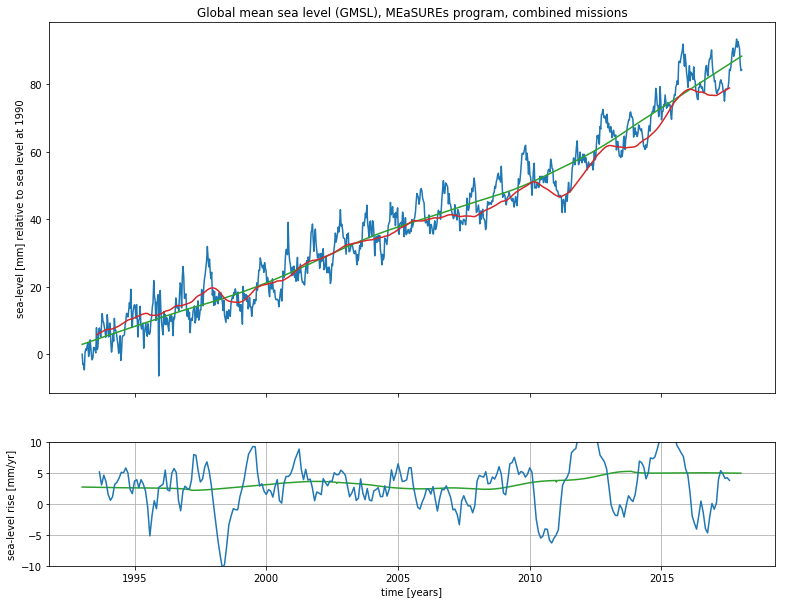

In [48]:
variable = 'GMSL GIA'
# compute lowess based on this fraction of the dataset
frac = 1/3.0
gmsl = df[variable] - df[variable].iloc[0]
year = 2019
selected = df[df.index <= year]
epoch = df.index[0]
lowess_result = statsmodels.nonparametric.smoothers_lowess.lowess(
    endog=gmsl, 
    exog=df[variable].index - epoch, 
    frac=frac
)

# STL method
monthly_means = df.reset_index().set_index('date')[[variable, 'year']].resample('M').mean()
decomposed = statsmodels.tsa.seasonal.seasonal_decompose(monthly_means[variable] - monthly_means[variable].iloc[0])


fig, axes = plt.subplots(2, 1, figsize=(13, 10), gridspec_kw=dict(height_ratios=(3, 1)), sharex=True)
axes[0].plot(df.index, gmsl)
axes[0].plot(df[variable].index, lowess_result[:, 1], label='lowess', color=colors['lowess'])
axes[0].plot(
    monthly_means.index.year + monthly_means.index.dayofyear/365.0, 
    decomposed.trend, 
    label='STL', 
    color=colors['STL']
)
axes[1].plot(
    df.index[:-1], 
    np.diff(lowess_result[:, 1])/np.diff(lowess_result[:,0]),
    color=colors['lowess'],
    label='lowess'
)

axes[1].plot(
    (monthly_means.index.year + monthly_means.index.dayofyear/365.0),
    decomposed.trend.diff()/monthly_means.year.diff()
)



axes[1].set_ylim(-10, 10)
axes[1].grid('on')


axes[0].set_title("Global mean sea level (GMSL), MEaSUREs program, combined missions")
axes[0].set_ylabel('sea-level [mm] relative to sea level at 1990')
axes[1].set_ylabel('sea-level rise [mm/yr]')
axes[1].set_xlabel('time [years]')

In [85]:
import statsmodels.tsa.regime_switching.markov_regression



result = statsmodels.tsa.regime_switching.markov_regression.MarkovRegression(
    df.set_index('date')[variable], 
    k_regimes=4,
    trend='ct'
)



/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:               GMSL GIA   No. Observations:                  922
Model:               MarkovRegression   Log Likelihood               -2395.680
Date:                Thu, 07 Jun 2018   AIC                           4833.360
Time:                        16:36:58   BIC                           4934.718
Sample:                    01-05-1993   HQIC                          4872.035
                         - 01-16-2018                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.5479      1.050    -15.758      0.000     -18.606     -14.490
x1             0.0396      0.002     20.024      0.000       0.036       0.043
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.8412      0.419    -73.566      0.000     -31.663     -30.020
x1             0.0727      0.001     90.055      0.000       0.071       0.074
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.4806      0.316   -121.909      0.000     -39.099     -37.862
x1             0.0917      0.001    160.167      0.000       0.091       0.093
                             Regime 3 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.7203      0.619    -81.910      0.000     -51.934     -49.507
x1             0.1145      0.001    121.040      0.000       0.113       0.116
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.5784      0.349     18.824      0.000       5.893       7.263
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9276      0.021     44.226      0.000       0.887       0.969
p[1->0]        0.0233      0.014      1.639      0.101      -0.005       0.051
p[2->0]        0.0182      0.011      1.596      0.110      -0.004       0.041
p[3->0]        0.0011      0.011      0.102      0.919      -0.021       0.023
p[0->1]        0.0547      0.035      1.564      0.118      -0.014       0.123
p[1->1]        0.8890      0.029     30.640      0.000       0.832       0.946
p[2->1]        0.0382      0.013      2.844      0.004       0.012       0.065
p[3->1]        0.0091      0.009      0.962      0.336      -0.009       0.028
p[

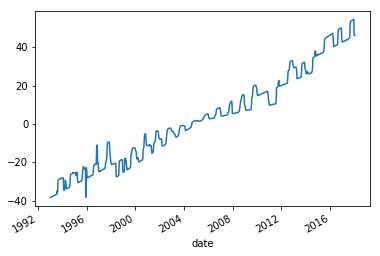

In [84]:
fitted = result.fit()
fitted.fittedvalues.plot()
fitted.summary()


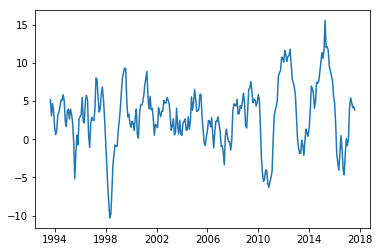

In [71]:
plt.plot(decomposed.trend.diff()/monthly_means.year.diff())

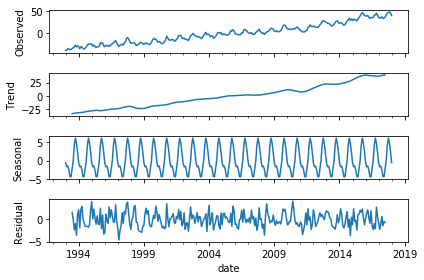

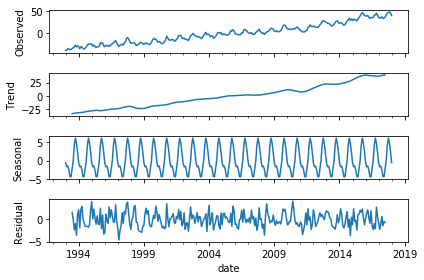

In [23]:

decomposed.plot()